This notebook is intended to be a tutorial for new SPICE/HeRALD members to get up to speed on what dIdVs are and how to use them. Additionally, it can serve as a reference for more experienced members when trying to remembe, say, the workflow for a specific process.

In this notebook, we take a single in transition dIdV, fit it, show how to display various fit parameters and plots, and then use these fits to construct a power noise spectrum, templates, and an OFAmp to energy conversion.

This notebook was written in May 2023 by Roger Romani, and various functions and best practices may have changed since then. Please feel free to reach out with questions, or to current collaboration members if Roger has graduated.

First, let's import the packages we'll need for this notebook:

In [1]:
#basic python imports
import numpy as np
import pickle

#plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 6.5]

#fft stuff
from scipy.fftpack import fft, ifft, fftfreq

#various QETpy functions
from qetpy.core.didv._uncertainties_didv import get_dPdI_with_uncertainties
from qetpy.core.didv._templates_didv import _p_delta_frequency, _p_pulse_frequency, get_didv_template, get_phonon_template
from qetpy.core.didv._templates_didv import get_simple_energy_normalization, get_energy_normalization
from qetpy.utils import make_template_twopole, make_template_threepole
from qetpy.core.didv._uncertainties_didv import get_power_noise_with_uncertainties, get_dPdI_with_uncertainties


import qetpy as qp

#for reading in data
from pytesdaq.io.hdf5 import H5Reader

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/site-packages/pytz/__init__.py:499: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/share/zoneinfo/zone.tab' mode='r' encoding='UTF-8'>
  for l in open(os.path.join(_tzinfo_dir, 'zone.tab'))
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 2

Now, let's load in some data. This loads in real Run 26 data from the analysis computer. Of course, the data you're looking at will change for your own analyses.

In [2]:
#this is the folder or file where data is located
path = '/sdata1/runs/run26/raw/continuous_I2_D20230321_T002644/didv_bor_I2_D20230321_T002714_F0001.hdf5'

#these are the channel(s) we want to analyze. For dIdVs, this should just be a single channel of data
chans = ['Melange025pcRight']

h5read = H5Reader()
traces_temp, metadata = h5read.read_many_events(
    filepath = path,
    nevents=-1, #this tells read_many_events to read all the events in the file
    output_format=2,
    detector_chans=chans,
    include_metadata=True, #we want the metadata to look at e.g. the device bias current
    adctoamp = True
)

Next, we'll format these traces into being just an array of data from the one channel that the dIdV is being done on, rather than an array of data from say all 4 channels for each event. We can also optionally do autocuts on this dIdV data.

In [3]:
traces = []
i = 10 #there can sometimes be data quality issues with the first few events in dIdVs
       #so we skip the first 10 events
while i < len(traces_temp):
    traces.append(traces_temp[i][0])
    i += 1

traces = np.asarray(traces)

#this line does autocuts on the traces and reduces traces to only good events
#can be commented out if it's being slow and the data is known to be high quality
traces = np.asarray(traces)[qp.autocuts_didv(np.asarray(traces))]

The next step constructs the dIdVfit object from all the relevent data.

In [4]:
#these parameters are loaded into the dIdV to make the smallsignalparameters correct
#later, these parameters are essentially refit from understanding the true current
#through the TES. However, we need to run the dIdV fit once first to get the dIdV
#offset fit.
rp = 0.003 #ohms, parasitic resistance
r0 = 0.182 #ohms, TES resistance at bias point
rsh = 5e-3 #ohms, shunt resistance, the standard Pyle group value
fs = int(1.25e6) #Hz, sampling frequency
sgfreq = float(metadata[0]['detector_config'][chans[0]]['signal_gen_frequency']) #the signal generator frequency
                                                                                 #read in directly from metadata
sgamp = float(metadata[0]['detector_config'][chans[0]]['signal_gen_current']) #the signal generator amplitude
                                                                              #read in directly from metadata


didvfit = qp.DIDV(
    traces,
    fs,
    sgfreq,
    sgamp,
    rsh,
    tracegain=1.0,
    r0=r0, # the expected r0 should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    rp=rp, # the expected rp should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    dt0=-1e-6, # a good estimate of the time shift value will likely speed up the fit/improve accuracy
    add180phase=False, # if the fits aren't working, set this to True to see if the square wave is off by half a period
)

We can now actually perform the fit for two and three pole models.

In [5]:
didvfit.dofit(2)
print("Done with Two Pole Fit")
didvfit.dofit(3)
print("Done with Three Pole Fit")

Done with Two Pole Fit
Done with Three Pole Fit


To get the correct smallsignalparameters, the biasparameters, the dPdI, etc., we need to know the true current through the TES at the bias point. We know part of this information from the fits we just did, where we fit the offset of the dIdV traces.

We also need to know the offset of this current offset to the true zero current, so we can know the true current through the TES. We do this by loading in a "offsets_dict" which was calculated earlier using the get_offset_dict function in the IVsweep class. I've made a second example notebook demonstrating this. This dictionary carries around the offsets for the current through the TES as well as the TES bias, and the parasitic resistance (which is fit from SC IV data).

In [6]:
save_dict_name = 'offsets_Melange025pcRight'
rq_files_path = '/sdata1/runs/run26/RQFiles/'

with open(rq_files_path + save_dict_name, 'rb') as handle:
    offsets_dict = pickle.load(handle)

print(offsets_dict)

{'i0_off': -1.3962684672160082e-07, 'i0_off_err': 8.679617681574973e-11, 'ibias_off': -4.2564347841914716e-08, 'ibias_off_err': 1.7434245885715748e-10, 'i0_changable_offset': -2.0903542e-07, 'rp': 0.002974632497225102, 'IVobj': <pytesdaq.processing._iv_didv_tools.IVanalysis object at 0x7fd2974d6208>}


In [7]:
channel_name = 'Melange025pcRight'

#gets information from the metadata loaded in when we loaded in traces to understand the offsets on the dIdV
output_offset = float(metadata[0]['detector_config'][channel_name]['output_offset'])
closed_loop_norm = float(metadata[0]['detector_config'][channel_name]['close_loop_norm'])
ibias_metadata = float(metadata[0]['detector_config'][channel_name]['tes_bias'])

Now, we can fit with the true bias parameters. We also get the results object, that we can look at to do things like what the true fall times are, what the bias power is, what the beta is, etc. etc.

In [8]:
didvfit.dofit_with_true_current(offsets_dict, output_offset, closed_loop_norm, ibias_metadata)
result = didvfit.fitresult(3) #this is the actual object we inspect when we want to know information
                                         #about the dIdV fit

Great! We now have a fit dIdV, and can start learning about our devices from our fits.











First, let's take a look at some plots to make sure the dIdV was actually fit in a reasonable way.

The first three plots we'll look at show the time domain dIdV fits. You can look at these to check for very obvious issues with e.g. the fall time getting fit wrong, the time offset being completely wrong, etc.

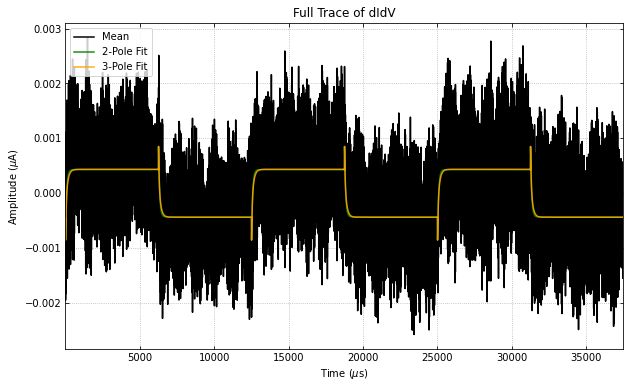

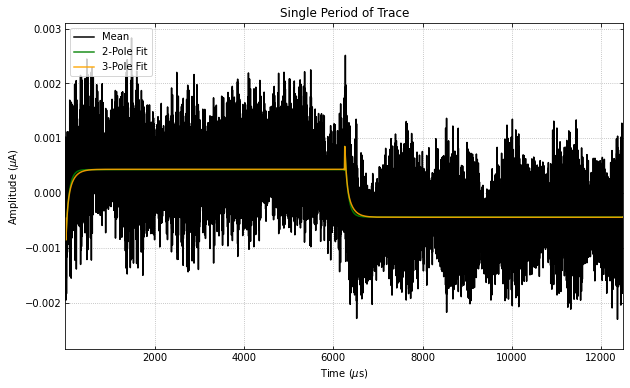

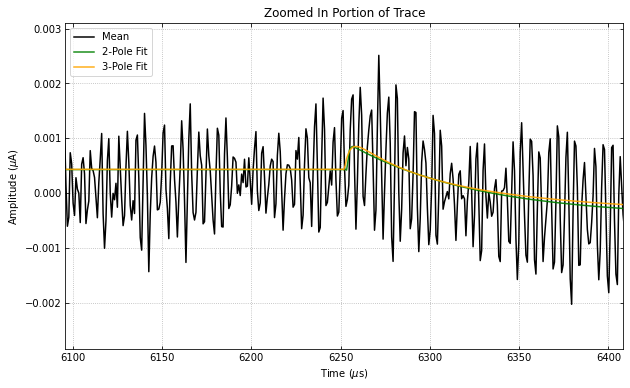

In [9]:
didvfit.plot_full_trace()
didvfit.plot_single_period_of_trace()
didvfit.plot_zoomed_in_trace(zoomfactor=0.025)

You'll notice that there's a lot of high frequency noise in these plots, even when plotting the mean trace that's been averaged from all our data. More data can always help, but we can intelligently filter our data to show only the information that the dIdV fits looks at. This is especially helpful for low bias power devices.

Because we know the frequency of the signal generator, and we know that for a square wave, you only excite the frequencies $f_{sq}(2n + 1)$ where $n$ is an integer, we can filter out all frequencies that aren't in these bins. This is essentially what the dIdV fit does itself, it only looks at the frequencies excited by the signal generator square wave.

We do this by using the didv_freq_filt = True flag.

We can also just low pass filter the data using the lp_cutoff = (cutoff frequency) flag. Of course, this reduces high frequency information, especially around the rising edge of the pulse, which is often faster than a logical cutoff frequency.

/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


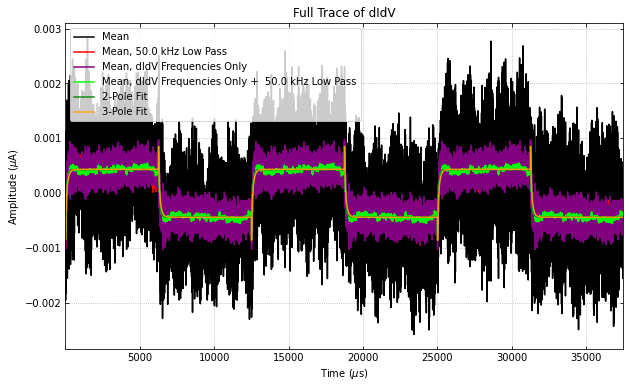

/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


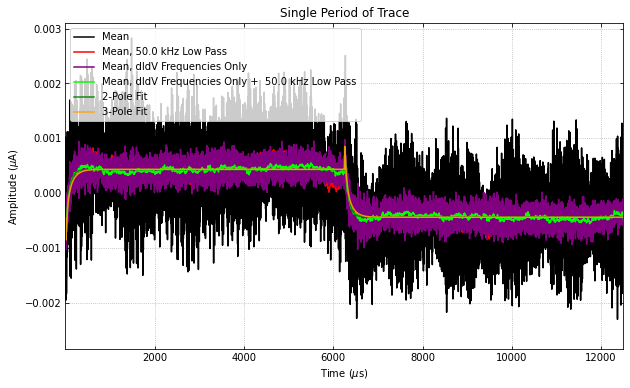

/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roger/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


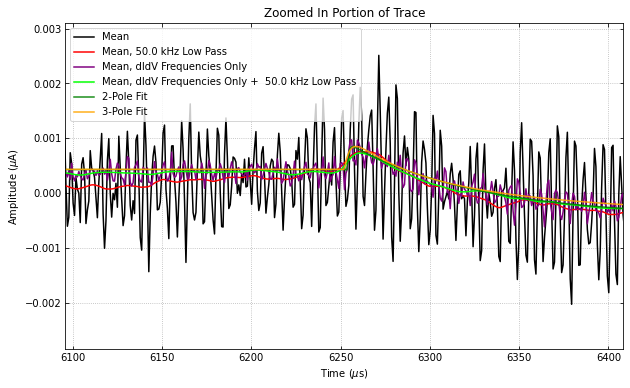

In [10]:
didvfit.plot_full_trace(didv_freq_filt = True, lp_cutoff = 50e3)
didvfit.plot_single_period_of_trace(didv_freq_filt = True, lp_cutoff = 50e3)
didvfit.plot_zoomed_in_trace(zoomfactor=0.025, didv_freq_filt = True, lp_cutoff = 50e3)

We also often want to make sure that we didn't run the signal generator at too high an amplitude when taking our dIdV data. We'd see this when the top and bottom of our dIdV are essentially at significantly different bias points, giving us things like different fall times for the dIdV.

We can check this by flipping and phase shifting the dIdV, and making sure that the origional and flipped and phase shifted dIdVs agree with each other:

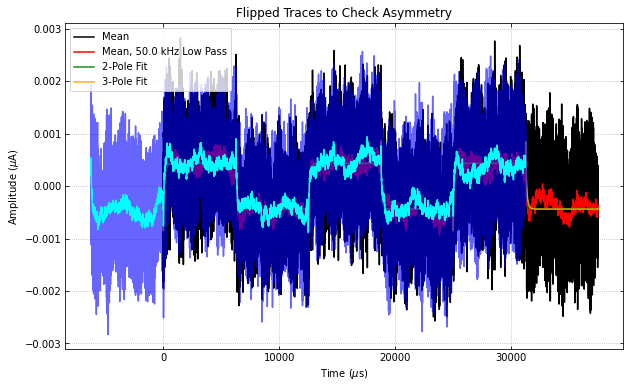

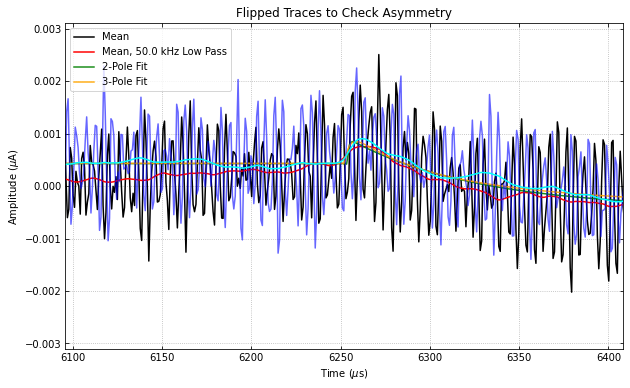

In [11]:
didvfit.plot_didv_flipped(lp_cutoff = 50e3)
didvfit.plot_didv_flipped(lp_cutoff = 50e3, zoomfactor = 0.025)

We can also look at the frequency domain fits (which is where the dIdV fitting actually happens).

Sometimes, when the dIdV signal generator amplutide is too high the fits essentially go non-linear, and we see in the imaginary part fits that the "bump" around a few kHz gets fit as negative rather than positive. We're still not entirely sure why this is... but the solution is generally to retake data with a smaller signal generator amplitude. If you can't retake data, start playing with the dIdV constraints perhaps.

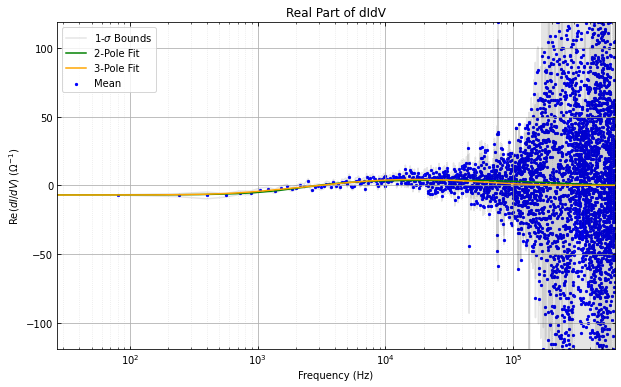

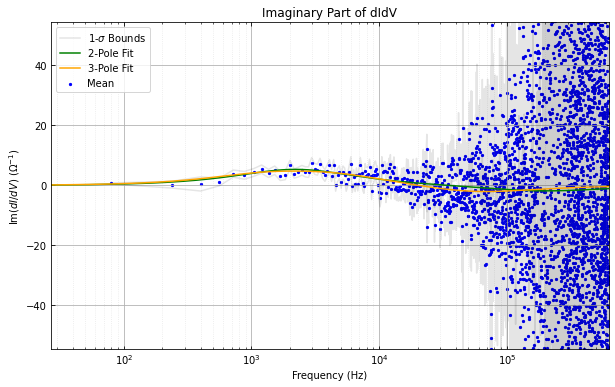

In [12]:
didvfit.plot_re_im_didv()

We've now checked that our fits are reasonable, and can start looking at the information that our fits tell us.

First, let's take a look at what was actually fit. For our three pole model, we fit the model to:

$\frac{dV}{dI}(f) = A(1 + 2 i \pi f \tau_2) + \frac{B}{1 + 2 i \pi f \tau_1 - C/(1 + 2 i \pi f \tau_3)}$

You can essentially ignore the third pole parameters ($C, \tau_3$) for the moment.

Let's print out the actual fits of these parameters (plus dt, the fit time offset), as well as their covariance matrix:

In [13]:
print("Fit parameters: ")
print(result['params'])
print(" ")
print("Fit covariance matrix: ")
print(result['cov'])

Fit parameters: 
{'A': 0.24670972204550767, 'B': -0.4918569726791902, 'C': -0.26114613452498486, 'tau1': -4.621903442658038e-05, 'tau2': 2.5281497317772485e-06, 'tau3': 7.67000468227613e-05, 'dt': 1.1635954344319605e-06}
 
Fit covariance matrix: 
[[ 1.37125325e-04  2.38008160e-04  1.04847564e-03  3.47808889e-08
  -1.62287129e-09  1.34853108e-07  6.29283884e-10]
 [ 2.38008280e-04  3.73791620e-03  1.03037581e-02  2.15391113e-07
  -1.21405122e-08  2.06778583e-06  3.27063006e-09]
 [ 1.04847595e-03  1.03037577e-02  2.97285086e-02  6.59730021e-07
  -3.62755042e-08  5.68903965e-06  1.03737973e-08]
 [ 3.47808944e-08  2.15391092e-07  6.59729984e-07  2.04960534e-11
  -7.67080018e-13  1.23388526e-10  3.38041269e-13]
 [-1.62287163e-09 -1.21405114e-08 -3.62755032e-08 -7.67080039e-13
   1.90957495e-13 -5.71994132e-12 -8.97318724e-14]
 [ 1.34853174e-07  2.06778582e-06  5.68903984e-06  1.23388538e-10
  -5.71994176e-12  1.51028002e-09  1.44571534e-12]
 [ 6.29283963e-10  3.27062964e-09  1.03737965e-08  

We can also take a look at the correlation matrix to see how the uncertainties in these variables are related:

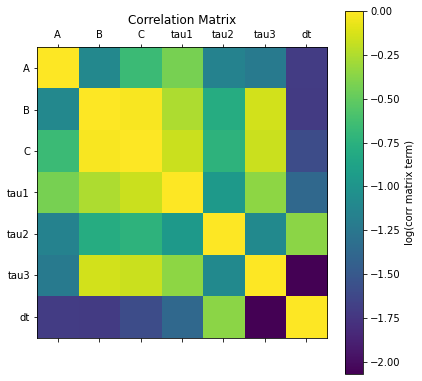

In [14]:
cov_matrix = result['cov']

#construct the correlation matrix
cor_matrix = np.zeros([7,7])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = np.abs(cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j])))
        j += 1
    i += 1
    
#plot the correlation matrix
labels = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']
ticks = np.arange(0, 7, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

We can see that there's lots of covariance between the second and third pole fit heights (B and C), and between $\tau_2$ and dt. Let's constrain those terms and refit, and see the correlation go down.

In [15]:
bounds_right = [np.asarray([0.15, -0.900, -1e-5, -4e-4, 0.00, 0.00, -0.5e-9]), #small
                np.asarray([0.60, -0.325, -1e-7, -2e-5, 3e-6, 4e-3, 0.5e-9])] #big
bounds_right = np.asarray(bounds_right)
guess_params = np.asarray([0.4, -0.5, -1e-6, -3e-5, 2e-6, 2e-3, 1e-10]) 

#refit using these bounds
didvfit.dofit_with_true_current(offsets_dict, output_offset, closed_loop_norm, ibias_metadata,
                                guess=guess_params, bounds=bounds_right)
result = didvfit.fitresult(3)

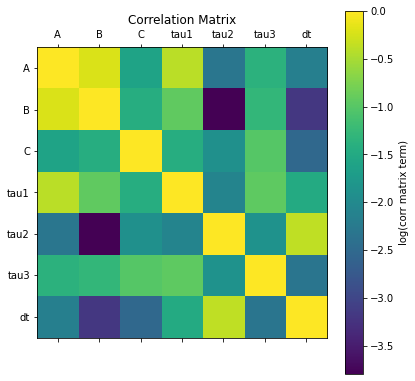

In [16]:
cov_matrix = result['cov']

#construct the correlation matrix
cor_matrix = np.zeros([7,7])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = np.abs(cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j])))
        j += 1
    i += 1
    
#plot the correlation matrix
labels = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']
ticks = np.arange(0, 7, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

We can see we reduced the correlation of B and C and $\tau_2$ and dt.

Now, let's take a look at the falltimes.

IT'S VERY IMPORTANT TO NOTE THAT THESE FIT FALLTIMES ARE NOT THE SAME AS THE DIDV POLES!

These parameters are fit in this way because it corresponds to a physical model, which separates the contributions of the electrical inductance and the thermal feedback in modeling the response of the system. For very low inductance and slow thermal systems, the fit parameters approach the true system poles, but aren't identical.

The true poles are also included in the result object.

In [17]:
print("Fit time constants, NOT dIdV Poles: ")
print("Tau1: " + str(np.abs(result['params']['tau1'])) + ' s')
print("Tau2: " + str(result['params']['tau2']) + ' s')
print("Tau3: " + str(result['params']['tau3']) + ' s')
print(" ")

print("True dIdV Poles: ")
print("Tau_plus: " + str(result['falltimes'][0]) + ' s')
print("Tau_minus: " + str(result['falltimes'][1]) + ' s')
print("Tau_third: " + str(result['falltimes'][2]) + ' s')

Fit time constants, NOT dIdV Poles: 
Tau1: 4.203015517396412e-05 s
Tau2: 2.9999999999999997e-06 s
Tau3: 0.0013676529055642614 s
 
True dIdV Poles: 
Tau_plus: 3.3882656415968614e-06 s
Tau_minus: 6.942197328545189e-05 s
Tau_third: 0.001367679791434801 s


We can also look at the fit bias parameters to understand our bias point. Strictly speaking, we don't need to do a dIdV fit to understand these (we could in principle calclate them just from knowing the current through the device, the parasitic and shunt resistance and the bias current) but it's much more convenient to calculate them as part of the dIdV fit.

They are used to update the smallsignalparameters with the true bias point, as well as calculate the dPdI.

In [18]:
print("Biasparams dict: ")
print(result['biasparams'])
print(" ")
print("i0: " + str(result['biasparams']['i0']) + " +/- " + str(result['biasparams']['i0_err']) + " amps")
print("r0: " + str(result['biasparams']['r0']) + " +/- " + str(result['biasparams']['r0_err']) + " ohms")
print("v0: " + str(result['biasparams']['v0']) + " +/- " + str(result['biasparams']['v0_err']) + " volts")
print("p0: " + str(result['biasparams']['p0']) + " +/- " + str(result['biasparams']['p0_err']) + " watts")
print(" ")
print("Bias power: " + str(result['biasparams']['p0'] * 1e15) + " fW")

Biasparams dict: 
{'i0': 1.2795299302696514e-07, 'i0_err': 1.9440388421624524e-10, 'v0': 2.1780966231422243e-08, 'v0_err': 1.4279747779330418e-12, 'r0': 0.17022631293065624, 'r0_err': 0.0002588720314278211, 'p0': 2.7869398203297335e-15, 'p0_err': 4.2382447245376265e-18}
 
i0: 1.2795299302696514e-07 +/- 1.9440388421624524e-10 amps
r0: 0.17022631293065624 +/- 0.0002588720314278211 ohms
v0: 2.1780966231422243e-08 +/- 1.4279747779330418e-12 volts
p0: 2.7869398203297335e-15 +/- 4.2382447245376265e-18 watts
 
Bias power: 2.7869398203297333 fW


Properties of the TES can also be calculated from the fit dIdV parameters. These are useful in for instance understanding the properties of the W TES film ($\beta$), how strong the electrothermal feedback is $\mathcal{L}$, etc. These paramaters are called the smallsignalparameters.

The main 5 parameters that are calculated for a 3 pole model are:
- ($\beta$, "beta", i.e. the current sensitivity)
- ($\mathcal{L}$, "l", i.e. the loopgain)
- ($L_{eff}$, "L", i.e. the effective system inductance at the bias point)
- ($\tau_0$, "tau0", i.e. the thermal time constant C/G)
- ("gratio", i.e. the ratio between the second and third pole thermal conductances G)

These, along with some other parameters, were packaged into a dict by Sam called the smallsignalparams dict.

If we want to know the covariances of these calculated parameters, it only really makes sense to talk about these 5 (or fewer, for fewer poles). Therefore, it doesn't really make sense to include "extra" parameters like rsh in the covariance matrix. I therefore made a new object for just these parameters, the ssp_light dict, which also includes a covariance matrix and the uncertainty on each parameter individually. I kept the smallsignalparams dict for backwards compatability.

In [19]:
print("smallsignalparameters dict:")
print(result['smallsignalparams'])
print(" ")
print(" ")

print("ssp_light dict: ")
print(result['ssp_light'])
print(" ")
print(" ")

print("Light SSP calculated values: ")
print(result['ssp_light']['vals'])
print(" ")
print("Light SSP calculated covariance matrix: ")
print(result['ssp_light']['cov'])
print(" ")
print("Light SSP uncertainties: ")
print(result['ssp_light']['sigmas'])

smallsignalparameters dict:
{'rsh': 0.005, 'rp': 0.002974632497225102, 'r0': 0.17022631293065624, 'beta': 0.5470570751303074, 'l': -24.796584691689386, 'L': 8.139733628698276e-07, 'tau0': -0.0010842344575500123, 'gratio': -0.0002579658451092427, 'tau3': 0.0013676529055642614, 'dt': 4.999999999999868e-10}
 
 
ssp_light dict: 
{'vals': {'beta': 0.5470570751303074, 'l': -24.796584691689386, 'L': 8.139733628698276e-07, 'tau0': -0.0010842344575500123, 'gratio': -0.0002579658451092427}, 'cov': array([[ 5.10511596e-03+0.j,  2.01841715e-01+0.j,  1.74700280e-09+0.j,
         1.13025765e-05+0.j,  2.63804409e-03+0.j],
       [ 2.01841740e-01+0.j,  1.35489200e+02+0.j, -1.63076940e-07+0.j,
         5.96393901e-03+0.j,  1.48896343e+00+0.j],
       [ 1.74700276e-09+0.j, -1.63076950e-07+0.j,  1.51371789e-14+0.j,
        -6.30271015e-12+0.j, -1.98328395e-09+0.j],
       [ 1.13025776e-05+0.j,  5.96393900e-03+0.j, -6.30270970e-12+0.j,
         2.65433706e-07+0.j,  6.51535968e-05+0.j],
       [ 2.63804413

Similarly to above, we can display a visualization of the correlation matrix:

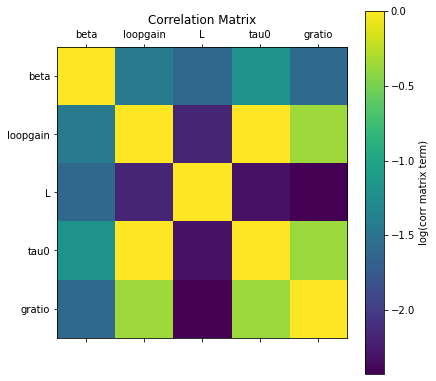

In [21]:
cov_matrix = np.abs(result['ssp_light']['cov'])
vals_vector = result['ssp_light']['vals']
cor_matrix = np.zeros([5,5])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j]))
        j += 1
    i += 1

labels = ['beta', 'loopgain', 'L', 'tau0', 'gratio']
ticks = np.arange(0, 5, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

As you can see, there's a lot of correlation between the loopgain and the tau0, far away from transition where the loopgain is large, they're highly correlated.

OK, now we've looked at most of the parameters of the dIdV. Let's show off a few more things the fit dIdV can do.

First, we can use it to construct a dPdI, and from that to understand our noise in the power as opposed to the current domain.

We'll load in some real noise separated into correlated and uncorrelated components to make this all somewhat meaningful.

In [22]:
noise_path = '/sdata1/runs/run26/RQFiles/noise_continuous_I2_D20230321_T002644'

with open(noise_path, 'rb') as handle:
    noise_dict = pickle.load(handle)
uncorrelated_noise_current = noise_dict['NC_all'].uncorrnoise[-1][1:]
correlated_noise_current = noise_dict['NC_LR'].corrnoise[-1][1:]
freqs = noise_dict['NC_all'].freqs[1:]
print("Loaded noise")

Loaded noise


We can now calculate and print the dPdI, and the uncorrelated and correlated noises in the power domain

Uncorrelated noise (only in TES):


/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1160: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1161: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1162: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1163: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1164: ComplexWarning: Casting 

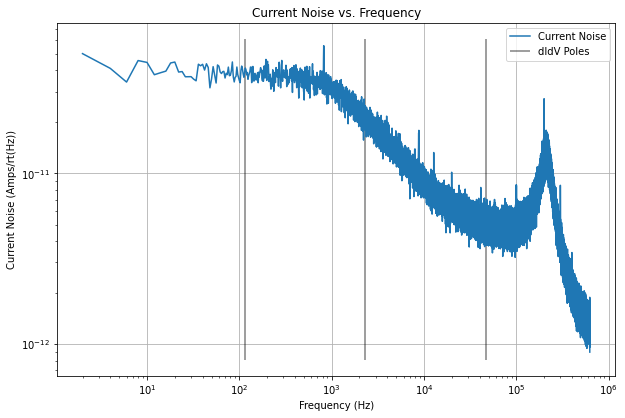

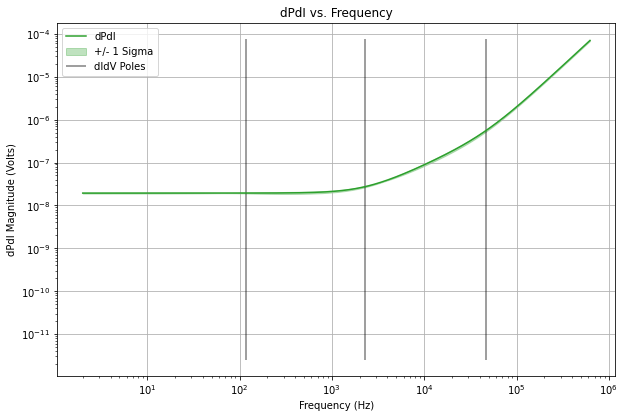

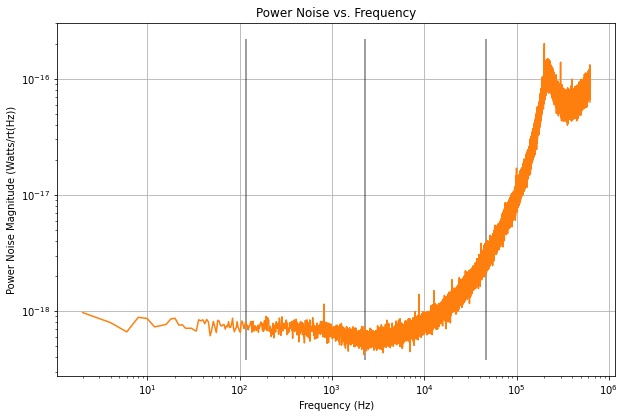

----------------------
Correlated noise (in phonon system):


/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1160: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1161: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1162: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1163: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1164: ComplexWarning: Casting 

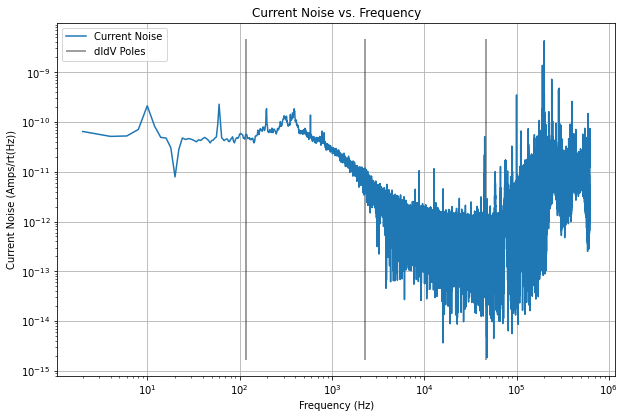

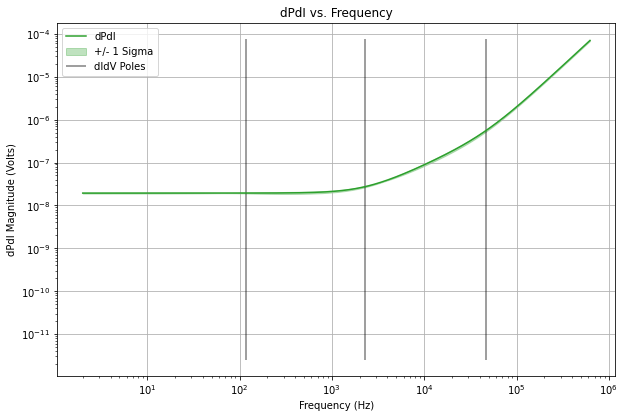

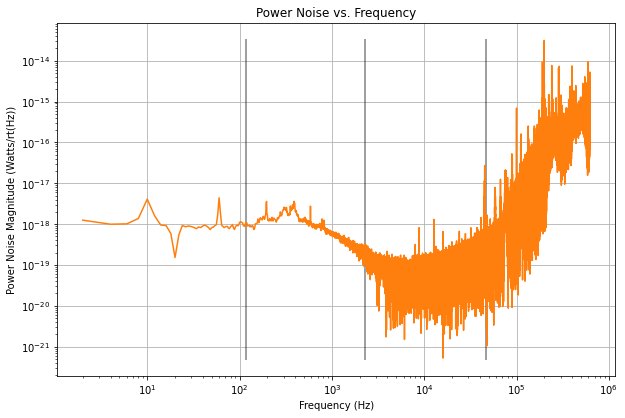

In [23]:
print("Uncorrelated noise (only in TES):")
uncor_noise_power, uncor_noise_power_err, dpdi, dpdi_err = get_power_noise_with_uncertainties(freqs,
                                                                              np.sqrt(uncorrelated_noise_current), 
                                                                              result, 
                                                                              lgcplots=True, lgcdpdireturn=True)

print("----------------------")
print("Correlated noise (in phonon system):")
cor_noise_power, cor_noise_power_err, dpdi, dpdi_err = get_power_noise_with_uncertainties(freqs,
                                                                          np.sqrt(correlated_noise_current), 
                                                                          result, 
                                                                          lgcplots=True, lgcdpdireturn=True)

Because we understand the dPdI, we can also make templates from just knowing the power domain input into the TES. There are two inputs to the TES that broadly make sense to construct templates from:
- delta function like power inputs to the TES. These would be from, for example, a photon being absorbed into the TES directly, or from a microfracture in the TES W.
- pulselike power input to the TES. This would be from a phonon mediated event, from e.g. DM, photons absorbed into the substrate, microfractures coupling through the phonon channel, etc.

In [24]:
# time array, 20 ms long, at a sample fequency fs
t_arr = np.arange(0, 2e-2, 1/fs)

template_didv = get_didv_template(t_arr, 1e-2, result)

phonon_falltime = 300e-6
template_phonon = get_phonon_template(t_arr, 1e-2, result, phonon_falltime)

/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_templates_didv.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  p_freqs[i] = np.exp(2.0j * np.pi * freqs[i] * start_time)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1160: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1161: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1162: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/roger/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1163: ComplexWarning: Casting c

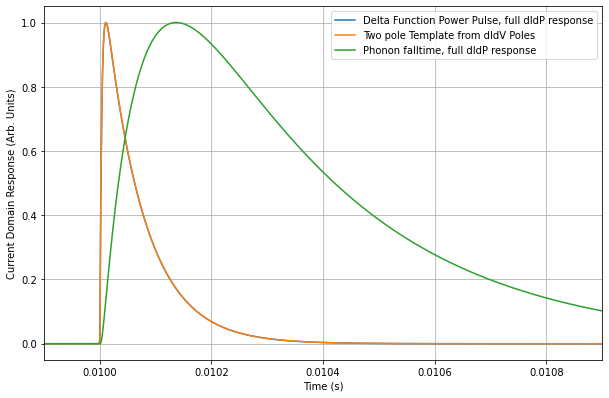

In [25]:
#For short times, we can show that this agrees with a 2 pole template calculated from the dIdV falltimes.
#At longer times, the third pole becomes important

plt.plot(t_arr, template_didv, label = "Delta Function Power Pulse, full dIdP response")

tau_p = np.abs(result['falltimes'][0])
tau_m = np.abs(result['falltimes'][1])

plt.plot(t_arr, make_template_twopole(t_arr, A = 1.0, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m),
        label = "Two pole Template from dIdV Poles")

plt.plot(t_arr, template_phonon, label = "Phonon falltime, full dIdP response")

plt.xlim(9.9e-3, 10.9e-3)
plt.ylabel("Current Domain Response (Arb. Units)")
plt.xlabel("Time (s)")
plt.grid()
plt.legend()
plt.show()

Finally, let's use dPdI response to get the factor we can use to transform between OFAmp units and enegy units (in units of eV or Joules)

In [26]:
ofamp_to_ev = get_energy_normalization(t_arr, template_phonon, result_biasparams, lgc_ev=True)
ofamp_to_joules = get_energy_normalization(t_arr, template_phonon, result_biasparams, lgc_ev=False)

NameError: name 'result_biasparams' is not defined